<a href="https://colab.research.google.com/github/dvschultz/stylegan2-training/blob/main/StyleGAN2_ADA_AudioReactive_Pitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#StyleGAN2 Reactive Audio

By Derrick Schultz for the StyleGAN2 Deep Dive class.

This notebook shows one basic example of how to alter your StyleGAN2 vectors with audio. There are lots of different techniques to explore in this, but this is one simple way.

Big thanks to Robert Luxemburg who provided the basis for a lot of this code with [this gist](https://gist.github.com/rolux/48f1da6cf2bc6ca5833dbacbf852b348).

##Installation

First let’s install the repos and dependencies needed.

In [1]:
%tensorflow_version 1.x

# Derrick's repo (even if you trained with skyflynil this will work!)
!git clone https://github.com/dvschultz/stylegan2-ada #use this fork to get interpolation functions
!pip install opensimplex # needed for noise interpolation
%cd stylegan2-ada

TensorFlow 1.x selected.
Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 173 (delta 4), reused 0 (delta 0), pack-reused 164
Receiving objects: 100% (173/173), 1.14 MiB | 2.49 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/stylegan2-ada


In [2]:
!nvidia-smi

Sun Oct 25 03:29:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!gdown --id 1K7mgdzdQwOERoyft95eFg1-5Tj4XcMAc -O /content/freagan.pkl

Downloading...
From: https://drive.google.com/uc?id=1K7mgdzdQwOERoyft95eFg1-5Tj4XcMAc
To: /content/freagan.pkl
382MB [00:04, 94.9MB/s]


## Upload an audio file

I recommend uploading something simple to start with (think a single instrument or track with silence in it). The file should be in .mp3 or .wav format.

In [4]:
from google.colab import files

uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving rushing-back-clip.wav to rushing-back-clip.wav


##Process audio
The next step process our audio files. Edit the first line of the next cell to point to your audio file. The run the cell after that to process the audio and generate a graph of the volume data.

In [7]:
wav_filename = '/content/stylegan2-ada/rushing-back-clip.wav'
fps = 24


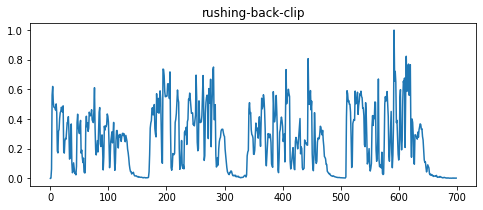

In [8]:
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import wavfile
import matplotlib.pyplot as plt
import PIL.Image
import moviepy.editor

import dnnlib
import dnnlib.tflib as tflib
import pickle
# import pretrained_networks

audio = {}

if not os.path.exists(wav_filename):
    audio_clip = moviepy.editor.AudioFileClip(wav_filename)
    audio_clip.write_audiofile(wav_filename, fps=44100, nbytes=2, codec='pcm_s16le')
track_name = os.path.basename(wav_filename)[:-4]
rate, signal = wavfile.read(wav_filename)
signal = np.mean(signal, axis=1) # to mono
signal = np.abs(signal)
# seed = signal.shape[0]
duration = signal.shape[0] / rate
frames = int(np.ceil(duration * fps))
samples_per_frame = signal.shape[0] / frames
audio[track_name] = np.zeros(frames, dtype=signal.dtype)
for frame in range(frames):
    start = int(round(frame * samples_per_frame))
    stop = int(round((frame + 1) * samples_per_frame))
    audio[track_name][frame] = np.mean(signal[start:stop], axis=0)
audio[track_name] /= max(audio[track_name])

for track in sorted(audio.keys()):
    plt.figure(figsize=(8, 3))
    plt.title(track)
    plt.plot(audio[track])
    plt.savefig(f'../{track}.png')

Run the next cell to define some functions we’ll need to use to generate our inference images.

In [10]:
import random
def generate_zs_from_seeds(seeds,Gs):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def generate_images_in_w_space(dlatents, truncation_psi,folder='random'):
    tflib.init_tf()
    print('Loading networks from "%s"...' % network_pkl)
    with dnnlib.util.open_url(network_pkl) as fp:
        _G, _D, Gs = pickle.load(fp)

    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    if folder == 'random':
      temp_dir = 'frames%06d'%int(1000000*random.random())
    else:
      temp_dir = folder
    os.system('mkdir %s'%temp_dir)

    for row, dlatent in enumerate(dlatents):
        print('Generating image for step %d/%d ...' % (row, len(dlatents)))
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        PIL.Image.fromarray(row_images[0], 'RGB').save('%s/frame%05d.png' % (temp_dir, row))

## Generate Images

### Use Volume to interpolate between two seeds
The next cell will take two seed values and do a linear interpolation of them using the volume from your audio. When the audio is silent, it will be the first seed you list. When it is at its loudest it will be the second. Everything in between will be an interpolated value.

In [ ]:
network_pkl = '/content/freagan.pkl'
seeds=[38,11]
truncation_psi = 0.5

#you probably won't need to edit anything below this
tflib.init_tf()
print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as fp:
    _G, _D, Gs = pickle.load(fp)

Gs_kwargs = {
    'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
    'randomize_noise': False
}
if truncation_psi is not None:
    Gs_kwargs['truncation_psi'] = truncation_psi
Gs_syn_kwargs = Gs_kwargs
Gs_syn_kwargs['minibatch_size'] = 4
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w_avg = Gs.get_var('dlatent_avg')

def get_ws(n, frames, seed):
    filename = f'../ws_{n}_{frames}_{seed}.npy'
    if not os.path.exists(filename):
        src_ws = np.random.RandomState(seed).randn(n, 512)
        ws = np.empty((frames, 512))
        for i in range(512):
            x = np.linspace(0, 3*frames, 3*len(src_ws), endpoint=False)
            y = np.tile(src_ws[:, i], 3)
            x_ = np.linspace(0, 3*frames, 3*frames, endpoint=False)
            y_ = interp1d(x, y, kind='quadratic', fill_value='extrapolate')(x_)
            ws[:, i] = y_[frames:2*frames]
        np.save(filename, ws)
    else:
        ws = np.load(filename)
    return ws

def lerp(v0, v1, t):
    # print(t)
    return v0*(1.0-t)+v1*t


ends = generate_zs_from_seeds(seeds,Gs)
ends_w = []

for e in range(len(ends)):
  ends_w.append(convertZtoW(ends[e],0.5))

vectors = []
for f in range(frames):
  vectors.append(lerp(ends_w[0],ends_w[1],audio[track_name][f]))

generate_images_in_w_space(vectors,truncation_value)


### Combine the frames into a video and add the audio track back to it

There’s probably a cleaner way to do this all in moviepy but I’m being lazy.

In [ ]:
!ffmpeg -r 24 -i /content/stylegan2-ada/frames488562/frame%05d.png -vcodec libx264 -pix_fmt yuv420p /content/freagan-ai-volume.mp4

In [ ]:
mp4_filename = '../freagan-ai-lerp-vol.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/freagan-ai-volume.mp4')
audio_clip_i = moviepy.editor.AudioFileClip('/content/stylegan2-ada/rushing-back-clip.wav')
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='15M')

## Pitch Control


In [ ]:
!pip install crepe

In [16]:
import crepe
from scipy.io import wavfile

sr, audio_w = wavfile.read(wav_filename)
time, frequency, confidence, activation = crepe.predict(audio_w, sr, viterbi=False,step_size=40)

729/729 [==============================] - 1s 1ms/sample


In [ ]:
def mapped(x):
  val = (x-minf)/(maxf-minf)
  return (val*(mapmax-mapmin))+mapmin

minf = min(frequency)
maxf = max(frequency)
mapmin = 0.0
mapmax = 1.0

for t in np.arange(len(time)):
  print(mapped(frequency[t]))

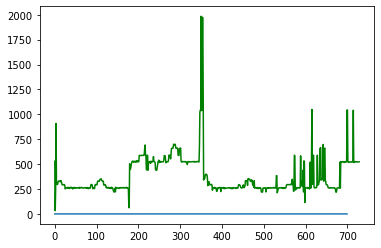

In [19]:

plt.plot(audio[track])
plt.plot(frequency,'g')
plt.show()

In [20]:
vectors = []
for f in range(frames):
  vectors.append(lerp(ends_w[0],ends_w[1],mapped(frequency[f])))

generate_images_in_w_space(vectors,truncation_value)

Loading networks from "/content/freagan.pkl"...
Generating image for step 0/700 ...
Generating image for step 1/700 ...
Generating image for step 2/700 ...
Generating image for step 3/700 ...
Generating image for step 4/700 ...
Generating image for step 5/700 ...
Generating image for step 6/700 ...
Generating image for step 7/700 ...
Generating image for step 8/700 ...
Generating image for step 9/700 ...
Generating image for step 10/700 ...
Generating image for step 11/700 ...
Generating image for step 12/700 ...
Generating image for step 13/700 ...
Generating image for step 14/700 ...
Generating image for step 15/700 ...
Generating image for step 16/700 ...
Generating image for step 17/700 ...
Generating image for step 18/700 ...
Generating image for step 19/700 ...
Generating image for step 20/700 ...
Generating image for step 21/700 ...
Generating image for step 22/700 ...
Generating image for step 23/700 ...
Generating image for step 24/700 ...
Generating image for step 25/700 ...


### Use Volume to control truncation
In this example, we’ll use almost the same technique but use volume to change the truncation value. 

It’s helpful that both interpolation and truncation are essentially 0.0 to 1.0. This matches the volume signal’s output, but what if we wanted to alter it?

In [ ]:
def mapped(x):
  val = (x-minf)/(maxf-minf)
  return (val*(mapmax-mapmin))+mapmin

# minf = min(frequency)
# maxf = max(frequency)
minf = 0.0
maxf = 1.0
print(minf,maxf)
mapmin = 0.4
mapmax = 0.8

# for t in np.arange(len(time)):
#   print(mapped(frequency[t]))

print(len(audio[track_name]))

for f in range(frames):
  print(mapped(audio[track_name][f]))

0.0 1.0
549
0.5002152942380154
0.5004073973577841
0.5004704691427148
0.5002633940810306
0.5004027366503198
0.5024726552018806
0.5060220017478589
0.5071252731768873
0.5065051484832893
0.5031931420242514
0.5008339996407977
0.5693171421199458
0.62533452022894
0.6243753794216954
0.5970390607451902
0.574616614946671
0.6469767565717527
0.6068825428295302
0.6177679319226621
0.5986939422178487
0.6430319571946574
0.6055822499462232
0.6269252360809348
0.619867768000428
0.5538704242055318
0.5081784033566181
0.5027028817694932
0.5022757649031888
0.5016124853373616
0.5038432123488231
0.5105280252496989
0.5019724067147397
0.5015697965358789
0.5015698152723912
0.5014650492355389
0.5016786064896885
0.5008860004889527
0.5005076845405071
0.5004432379639777
0.5009240449774196
0.500876175530253
0.5009544215985529
0.5010432185646612
0.5006316523328639
0.5004706822705435
0.5377028141105752
0.6725204594225633
0.6081069598637321
0.5812054172737833
0.5609599661052802
0.6976397943194665
0.6053675201456445
0.606

In [ ]:
seeds=[10]

#you probably won't need to edit anything below this
tflib.init_tf()
print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as fp:
    _G, _D, Gs = pickle.load(fp)

Gs_kwargs = {
    'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
    'randomize_noise': False
}
if truncation_psi is not None:
    Gs_kwargs['truncation_psi'] = truncation_psi
Gs_syn_kwargs = Gs_kwargs
Gs_syn_kwargs['minibatch_size'] = 4
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w_avg = Gs.get_var('dlatent_avg')

seed_z = generate_zs_from_seeds(seeds,Gs)

rnd = np.random.RandomState(seeds[0])

temp_dir = '%s-trunc_frames%06d'%(track_name,int(1000000*random.random()))
os.system('mkdir %s'%temp_dir)

for f in range(frames):
  print('Rendering frame %d/%d ...' % (f,frames))
  Gs_kwargs.truncation_psi = mapped(audio[track_name][f])
  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
  images = Gs.run(seed_z[0], None, **Gs_kwargs) # [minibatch, height, width, channel]
  PIL.Image.fromarray(images[0], 'RGB').save('%s/frame%05d.png' % (temp_dir,f))

Rendering frame 0/549 ...
Rendering frame 1/549 ...
Rendering frame 2/549 ...
Rendering frame 3/549 ...
Rendering frame 4/549 ...
Rendering frame 5/549 ...
Rendering frame 6/549 ...
Rendering frame 7/549 ...
Rendering frame 8/549 ...
Rendering frame 9/549 ...
Rendering frame 10/549 ...
Rendering frame 11/549 ...
Rendering frame 12/549 ...
Rendering frame 13/549 ...
Rendering frame 14/549 ...
Rendering frame 15/549 ...
Rendering frame 16/549 ...
Rendering frame 17/549 ...
Rendering frame 18/549 ...
Rendering frame 19/549 ...
Rendering frame 20/549 ...
Rendering frame 21/549 ...
Rendering frame 22/549 ...
Rendering frame 23/549 ...
Rendering frame 24/549 ...
Rendering frame 25/549 ...
Rendering frame 26/549 ...
Rendering frame 27/549 ...
Rendering frame 28/549 ...
Rendering frame 29/549 ...
Rendering frame 30/549 ...
Rendering frame 31/549 ...
Rendering frame 32/549 ...
Rendering frame 33/549 ...
Rendering frame 34/549 ...
Rendering frame 35/549 ...
Rendering frame 36/549 ...
Rendering f

In [ ]:
!ffmpeg -r 12 -i /content/stylegan2/bass-trunc_frames844699/frame%05d.png -vcodec libx264 -pix_fmt yuv420p /content/bass-truncation-volume.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [ ]:
mp4_filename = '../volume-trunc-test-all.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/bass-truncation-volume.mp4')
audio_clip_i = moviepy.editor.AudioFileClip('/content/AI.mp3')
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='8M')

[MoviePy] >>>> Building video ../volume-trunc-test-all.mp4
[MoviePy] Writing audio in volume-trunc-test-allTEMP_MPY_wvf_snd.mp4


100%|██████████| 1008/1008 [00:01<00:00, 622.07it/s]

[MoviePy] Done.
[MoviePy] Writing video ../volume-trunc-test-all.mp4



100%|█████████▉| 549/550 [00:38<00:00, 14.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../volume-trunc-test-all.mp4 



In [ ]:
seeds=[10]

seed_z = generate_zs_from_seeds(seeds,Gs)

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False

rnd = np.random.RandomState(seeds[0])
temp_dir = '%s-trunc_frames%06d'%(track_name,int(1000000*random.random()))
os.system('mkdir %s'%temp_dir)

for f in range(frames):
  print('Rendering frame %d/%d ...' % (f,frames))

  #edit the next line to alter the volume signal
  # new_truncation_value = audio[track_name][f]*2 #multiply by 2 (0.0 to 2.0 for volume signal/truncation value now)
  new_truncation_value = (audio[track_name][f]-0.5)*2 #(-1.0 to 1.0 for volume signal/truncation value now)

  Gs_kwargs.truncation_psi = new_truncation_value
  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
  images = Gs.run(seed_z[0], None, **Gs_kwargs) # [minibatch, height, width, channel]
  PIL.Image.fromarray(images[0], 'RGB').save('%s/frame%05d.png' % (temp_dir,f))

In [ ]:
!ffmpeg -r 60 -i /content/stylegan2/pleasureisallmine_01-stereo-trunc_frames623374/frame%05d.png -vcodec libx264 -pix_fmt yuv420p /content/sound-truncation-volume.mp4

In [ ]:
mp4_filename = '../volume-trunc-test-v3.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/sound-truncation-volume.mp4')
audio_clip_i = moviepy.editor.AudioFileClip('/content/stylegan2/pleasureisallmine_01-stereo.wav')
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='8M')

[MoviePy] >>>> Building video ../volume-trunc-test-v3.mp4
[MoviePy] Writing audio in volume-trunc-test-v3TEMP_MPY_wvf_snd.mp4


100%|██████████| 128/128 [00:00<00:00, 701.72it/s]

[MoviePy] Done.
[MoviePy] Writing video ../volume-trunc-test-v3.mp4



100%|██████████| 347/347 [00:13<00:00, 25.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../volume-trunc-test-v3.mp4 



## Using feature vectors

Let’s look at an example using a feature vector. In this case we’ll just use the straight audio signal.

Upload your feature vector to Colab and then reference it’s location with a variable.

In [ ]:
network_pkl = "/content/ffhq.pkl"

tflib.init_tf()
print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as fp:
    _G, _D, Gs = pickle.load(fp)

Gs_kwargs = {
    'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
    'randomize_noise': False
}
if truncation_psi is not None:
    Gs_kwargs['truncation_psi'] = truncation_psi
Gs_syn_kwargs = Gs_kwargs
Gs_syn_kwargs['minibatch_size'] = 4
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w_avg = Gs.get_var('dlatent_avg')

def generate_mov(seed, truncation, direction_vec, scale, n_frames, out_name = 'out', noise_spec = None, loop=True):
  """Generates a mov moving back and forth along the chosen direction vector"""
  # Example of reading a generated set of images, and storing as MP4.
  %mkdir out
  movieName = f'out/{out_name}.mp4'
  offset = -10
  step = 20 / n_frames
  imgs = []
  for i in range(n_frames):
    print(f'{i} / {n_frames}')
    
    
    batch_size = 1
    all_seeds = [seed] * batch_size
    all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds]) # [minibatch, component]
    all_w = Gs.components.mapping.run(all_z, None) # [minibatch, layer, component]
    if truncation != 1:
        w_avg = Gs.get_var('dlatent_avg')
        all_w = w_avg + (all_w - w_avg) * truncation # [minibatch, layer, component]
    all_w += direction_vec * offset * scale
    all_images = Gs.components.synthesis.run(all_w, **Gs_syn_kwargs)
    #save image and display
    final_im = PIL.Image.fromarray(np.median(all_images, axis=0).astype(np.uint8))
    imgs.append(final_im)
    #increase offset
    offset += step
  if loop:
    imgs += imgs[::-1]
  with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [ ]:
seed = 10 # starting seed (will appear at 0.5)
truncation = 0.7
feature = '/content/profile-c2.npy'
feature_range = 2 # feature_range maps the range of change in features 
scale = 1 # scale multiples the strength of the feature (1 is prob fine)

#-------------------

tflib.init_tf()
print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as fp:
    _G, _D, Gs = pickle.load(fp)

Gs_kwargs = {
    'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
    'randomize_noise': False
}
if truncation_psi is not None:
    Gs_kwargs['truncation_psi'] = truncation_psi
Gs_syn_kwargs = Gs_kwargs
Gs_syn_kwargs['minibatch_size'] = 4
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w_avg = Gs.get_var('dlatent_avg')

# get starting z and w
rnd = np.random.RandomState(seed)
z = rnd.randn(1, *Gs.input_shape[1:])
w = Gs.components.mapping.run(z, None)

# make dir
feature_name=os.path.basename(feature)[:-4] 
dir = '%s_%s_range%02d_seed%05d'%(track_name,feature_name,feature_range,seed)
os.system('mkdir %s'%dir)

# setup
feature_vec = np.load(feature)
min_range = -feature_range
max_range = feature_range
offset = min_range #start value

#generate frames
for f in range(frames):
  print('Rendering frame %d/%d ...' % (f,frames))

  if truncation != 1:
    w = w_avg + (w - w_avg) * truncation # [minibatch, layer, component]
  
  w += feature_vec * offset * scale

  #save image and display
  image = Gs.components.synthesis.run(w, **Gs_syn_kwargs)
  PIL.Image.fromarray(image[0],'RGB').save('%s/frame%05d.png' % (dir,f))
  
  #increase offset
  offset = lerp( min_range,max_range,audio[track_name][f] )

  

In [ ]:
!ffmpeg -r 60 -i /content/stylegan2/pleasureisallmine_01-stereo_profile-c2_range02_seed00010/frame%05d.png -vcodec libx264 -pix_fmt yuv420p /content/sound-feature-volume-range2.mp4

In [ ]:
mp4_filename = '../volume-feature-test-range2.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/sound-feature-volume-range2.mp4')
audio_clip_i = moviepy.editor.AudioFileClip('/content/stylegan2/pleasureisallmine_01-stereo.wav')
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='8M')

[MoviePy] >>>> Building video ../volume-feature-test-range2.mp4
[MoviePy] Writing audio in volume-feature-test-range2TEMP_MPY_wvf_snd.mp4


100%|██████████| 128/128 [00:00<00:00, 640.23it/s]

[MoviePy] Done.
[MoviePy] Writing video ../volume-feature-test-range2.mp4



100%|██████████| 347/347 [00:15<00:00, 22.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../volume-feature-test-range2.mp4 

